### Classification with DNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F

In [2]:
from torchvision import datasets, transforms

In [3]:
train = datasets.MNIST(
    '../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)
test = datasets.MNIST(
    '../data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

In [4]:
def plot(x):
    img = (np.array(x.detach().cpu(), dtype='float')).reshape(28, 28)
    
    plt.imshow(img, cmap='gray')
    plt.show()

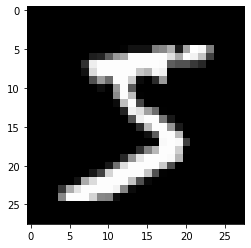

In [5]:
plot(train.data[0])

In [6]:
x = train.data.float() / 255.
y = train.targets

print(x.shape, y.shape)

torch.Size([60000, 28, 28]) torch.Size([60000])


In [7]:
x = x.view(x.size(0), -1)
print(x.shape)

torch.Size([60000, 784])


In [8]:
input_size = x.size(-1)
output_size = int(max(y)) + 1

In [9]:
print(f'input_size: {input_size}    /   output_size: {output_size}')

input_size: 784    /   output_size: 10


In [10]:
# split train / valid
ratios = [.8, .2]

train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) * ratios[1])
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

print(f"Train{train_cnt}/ Valid{valid_cnt}/ Test{test_cnt}")

indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

x += [(test.data.float() / 255.).view(test_cnt, -1)]
y += [test.targets]

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

Train48000/ Valid12000/ Test10000
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [11]:
model = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.LeakyReLU(),
    nn.Linear(500, 400),
    nn.LeakyReLU(),
    nn.Linear(400, 300),
    nn.LeakyReLU(),
    nn.Linear(300, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 50),
    nn.LeakyReLU(),
    nn.Linear(50, output_size),
    nn.LogSoftmax(dim=-1)
)

model

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=500, out_features=400, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=400, out_features=300, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=300, out_features=200, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=200, out_features=100, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=100, out_features=50, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Linear(in_features=50, out_features=10, bias=True)
  (13): LogSoftmax(dim=-1)
)

In [12]:
crit = nn.NLLLoss()

In [13]:
optimizer = optim.Adam(model.parameters())

### move to gpu

In [14]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [15]:
model = model.to(device)

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

### Train

In [16]:
n_epochs = 1000
batch_size = 256
print_interval = 10

In [17]:
from copy import deepcopy

lowest_epoch = np.inf
lowest_loss = np.inf

best_model = None
early_stop = 50

In [18]:
train_history, valid_history = [], []

for i in range(n_epochs):
    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for x_i, y_i in zip(x_, y_):

        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        train_loss += float(loss)

    train_loss = train_loss / len(x_)
        
    
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())

            valid_loss += float(loss)
            y_hat += [y_hat_i]

    valid_loss = valid_loss / len(x_)


    train_history += [train_loss]
    valid_history += [valid_loss]

    if (i + 1) % print_interval == 0:
        print('Epoch:%d . train_loss:%.4e . valid_loss:%.4e . lowest_loss:%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss
        ))
    
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i

        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and early_stop + lowest_epoch < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break


print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)

Epoch:10 . train_loss:2.6189e-02 . valid_loss:1.1127e-01 . lowest_loss:1.0930e-01
Epoch:20 . train_loss:8.6749e-03 . valid_loss:1.3841e-01 . lowest_loss:1.0930e-01
Epoch:30 . train_loss:6.3955e-03 . valid_loss:1.2624e-01 . lowest_loss:1.0930e-01
Epoch:40 . train_loss:3.1013e-03 . valid_loss:1.6059e-01 . lowest_loss:1.0930e-01
Epoch:50 . train_loss:6.7987e-03 . valid_loss:1.4077e-01 . lowest_loss:1.0930e-01
There is no improvement during last 50 epochs.
The best validation loss from epoch 8: 1.0930e-01


<All keys matched successfully>

### Loss history

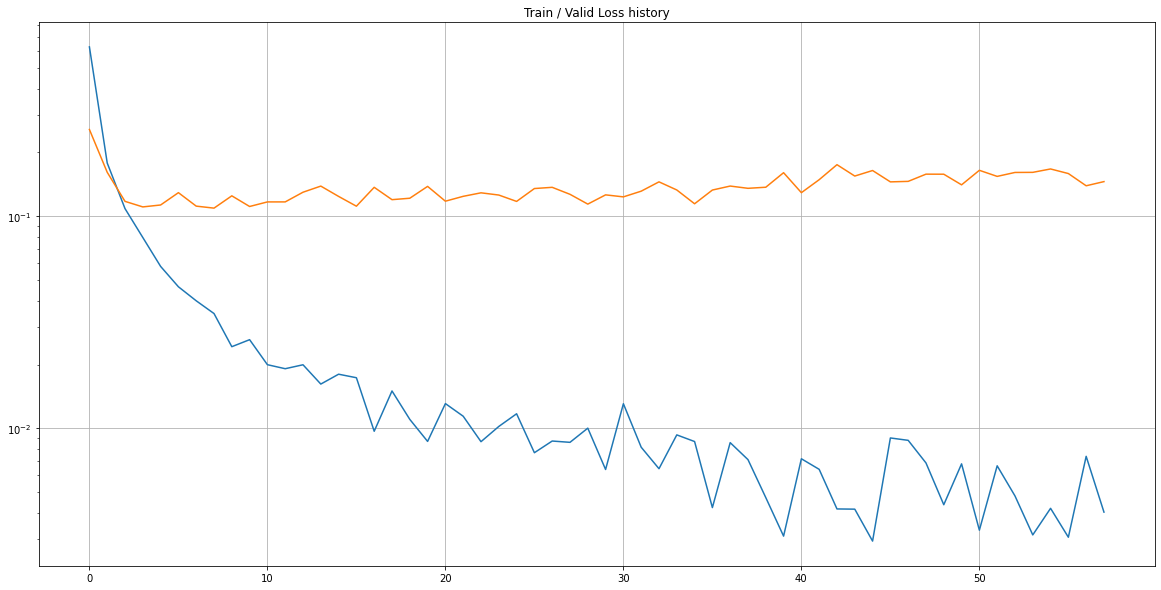

In [19]:
plot_form = 0

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss history")
plt.plot(
    range(plot_form, len(train_history)), train_history[plot_form:],
    range(plot_form, len(valid_history)), valid_history[plot_form:],
)
plt.yscale('log')
plt.show()

### test

In [20]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i)

        test_loss += loss
        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

print("Validation loss: %.4e" % test_loss)

Validation loss: 9.2430e-02


In [21]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print('Accuracy: %.4f' % (correct_cnt / total_cnt))

Accuracy: 0.9742


In [22]:
import pandas as pd
from sklearn.metrics import confusion_matrix

In [23]:
pd.DataFrame(confusion_matrix(y[-1], torch.argmax(y_hat, dim=-1)),
    index=['true_%d' % i for i in range(10)],
    columns=['pred_%d' % i for i in range(10)])

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,968,2,1,1,2,1,1,0,1,3
true_1,0,1130,0,0,0,2,1,0,2,0
true_2,3,6,999,7,1,0,0,6,10,0
true_3,0,0,2,992,0,4,0,8,3,1
true_4,0,2,4,0,966,0,4,3,1,2
true_5,2,0,0,13,1,869,2,0,3,2
true_6,5,3,0,1,6,8,932,0,3,0
true_7,1,7,7,3,0,0,0,1006,0,4
true_8,2,1,8,11,3,10,1,3,932,3
true_9,2,12,0,7,20,1,0,15,4,948
